In [105]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, MNIST
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import os

DEVICE = torch.device('cuda')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [106]:
def switch_to_device(dataset,device=None):
    final_X, final_Y = [], []
    for x, y in dataset:
        final_X.append(x)
        final_Y.append(y)
    X = torch.stack(final_X)
    Y = torch.tensor(final_Y)
    if device is not None:
        X = X.to(device)
        Y = Y.to(device)
    return TensorDataset(X, Y)

In [107]:
def get_Cifar10_dl(batch_size_train=256, batch_size_eval=1024, device=DEVICE):
    transform = transforms.Compose([transforms.ToTensor()])
    
    data_train = CIFAR10('./datasets', train=True, download=True, transform=transform)
    data_train = switch_to_device(data_train, device=device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [45000,5000])
    
    data_test = CIFAR10('./datasets', train=False, download=True, transform=transform)
    data_test = switch_to_device(data_test, device=device)
    
    train_dl = DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
    valid_dl = DataLoader(data_valid, batch_size=batch_size_eval, shuffle=False)
    test_dl = DataLoader(data_test, batch_size=batch_size_eval, shuffle=False)
    
    return train_dl, valid_dl, test_dl

In [108]:
def get_mnist_dl(batch_size_train=1024, batch_size_eval=1024, device=torch.device('cuda')):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])
    
    data_train = MNIST('./datasets', train=True, download=True, transform=transform)
    data_train = switch_to_device(data_train, device=device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [55000,5000])
    
    data_test = MNIST('./datasets', train=False, download=True, transform=transform)
    data_test = switch_to_device(data_test, device=device)
    
    train_dl = DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
    valid_dl = DataLoader(data_valid, batch_size=batch_size_eval, shuffle=False)
    test_dl = DataLoader(data_test, batch_size=batch_size_eval, shuffle=False)
    
    return train_dl, valid_dl, test_dl

In [109]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [110]:
def print_stats(stats):

  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3), dpi=110)
  ax1.grid()
  ax2.grid()

  ax1.set_title("ERM loss")
  ax2.set_title("Valid Acc")
  
  ax1.set_xlabel("iterations")
  ax2.set_xlabel("iterations")

  itrs = [x[0] for x in stats['train-loss']]
  loss = [x[1].cpu().detach().numpy() for x in stats['train-loss']]
  ax1.plot(itrs, loss)

  itrs = [x[0] for x in stats['valid-acc']]
  acc = [x[1] for x in stats['valid-acc']]
  ax2.plot(itrs, acc)

  ax1.set_ylim(0.0, max(loss))
  ax2.set_ylim(0.0, 1.05)
  fig.savefig('testing.jpg', bbox_inches = 'tight')

In [111]:
@torch.no_grad()
def get_acc(model, dl, device = DEVICE):
    acc = []

    for X, y in dl:
        #y = y//2
        #one_hot_y = torch.zeros(X.shape[0], 5).to(device)
        #one_hot_y[[i for i in range(X.shape[0])], [k.item() for k in y]] = 1
        res = model.eval_forward(X)
        acc.append(res == y)

    acc = torch.cat(acc)
    acc = torch.sum(acc)/len(acc)

    return acc.item()

In [112]:
def embed_label(x, y):
    x_ = x.clone()
    x_[:, :10] *= 0
    x_[range(x.shape[0]), y] = 1
    return x_

In [113]:
class FFA_Linear(nn.Linear):
    def __init__(self, in_dim, out_dim, bias=True, device=DEVICE):
        super().__init__(in_dim, out_dim, bias, DEVICE)
        self.act = torch.nn.ReLU()
        self.opt = torch.optim.Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0

    def eval_forward(self, x):
        x = x / (torch.norm(x, dim = 1, keepdim = True) + 1e-4)
        return self.act(x@self.weight.T + self.bias.unsqueeze(0))
    
    def train_forward(self, x_pos, x_neg):
        goodness_pos = self.eval_forward(x_pos).pow(2).mean(dim = 1)
        goodness_neg = self.eval_forward(x_neg).pow(2).mean(dim = 1)
        
        loss = torch.log(1 + torch.exp(torch.cat([-goodness_pos + self.threshold + 0.8, goodness_neg - self.threshold - 0.8]))).mean()
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        return loss, self.eval_forward(x_pos).detach(), self.eval_forward(x_neg).detach()


In [114]:
class LeNet(nn.Module):

  def __init__(self, num_classes=10):
    super().__init__()
    self.fc1 = FFA_Linear(28*28, 1024)
    self.fc2 = FFA_Linear(1024, 1024)
    self.fc3 = FFA_Linear(1024, 1024)
    self.fc4 = FFA_Linear(1024, num_classes)

    self.num_classes = num_classes

  def train_forward(self, x_pos, x_neg):
    loss = 0
    new_loss, x_pos, x_neg = self.fc1.train_forward(x_pos, x_neg)
    loss += new_loss
    new_loss, x_pos, x_neg = self.fc2.train_forward(x_pos, x_neg)
    loss += new_loss
    new_loss, x_pos, x_neg = self.fc3.train_forward(x_pos, x_neg)
    loss += new_loss
    new_loss, x_pos, x_neg = self.fc4.train_forward(x_pos, x_neg)
    loss += new_loss
    return loss

  def eval_forward(self, x):
    goodness_per_label = []
    for label in range(self.num_classes):
      embed_x = embed_label(x, label)
      goodness = []
      embed_x = self.fc1.eval_forward(embed_x)
      goodness += [embed_x.pow(2).mean(1)]
      embed_x = self.fc2.eval_forward(embed_x)
      goodness += [embed_x.pow(2).mean(1)]
      embed_x = self.fc3.eval_forward(embed_x)
      goodness += [embed_x.pow(2).mean(1)]
      embed_x = self.fc4.eval_forward(embed_x)
      goodness += [embed_x.pow(2).mean(1)]
      goodness_per_label += [sum(goodness).unsqueeze(1)]
    goodness_per_label = torch.cat(goodness_per_label, dim = 1)
    return goodness_per_label.argmax(dim = 1)



In [115]:
def run_experiment(model, train_dl, valid_dl, test_dl, max_epochs = 20, device = DEVICE):
    itr = -1
    stats = {'train-loss' : [], 'valid-acc' : []}
    
    for epoch in range(max_epochs):
        for x, y in train_dl:
            itr += 1
            x_pos = embed_label(x, y)
            rnd = torch.randperm(x.size(0))
            x_neg = embed_label(x, y[rnd])
            loss = model.train_forward(x_pos,x_neg)
            stats['train-loss'].append((itr, loss))

            if itr % 100 == 0:
                valid_acc = get_acc(model, valid_dl)
                stats['valid-acc'].append((itr, valid_acc))
                s = f"{epoch}:{itr} [train] loss:{loss.item():.3f}, [valid] acc:{valid_acc:.3f}"
                print(s)
    test_acc = get_acc(model, test_dl)
    print(f"[test] acc:{test_acc:.3f}")

    return stats

In [116]:
model = LeNet().to(DEVICE)
print(count_parameters(model))

train_batch_size = 128
test_batch_size = 1024
train_dl, valid_dl, test_dl = get_mnist_dl(train_batch_size, test_batch_size, device = DEVICE)

max_epochs = 200

2913290


0:0 [train] loss:5.835, [valid] acc:0.086
0:100 [train] loss:2.790, [valid] acc:0.117
0:200 [train] loss:2.724, [valid] acc:0.220
0:300 [train] loss:2.584, [valid] acc:0.333
0:400 [train] loss:2.378, [valid] acc:0.485
1:500 [train] loss:2.292, [valid] acc:0.752
1:600 [train] loss:2.279, [valid] acc:0.791
1:700 [train] loss:2.141, [valid] acc:0.833
1:800 [train] loss:2.112, [valid] acc:0.848
2:900 [train] loss:2.019, [valid] acc:0.847
2:1000 [train] loss:1.980, [valid] acc:0.859
2:1100 [train] loss:1.971, [valid] acc:0.853
2:1200 [train] loss:1.827, [valid] acc:0.875
3:1300 [train] loss:1.877, [valid] acc:0.880
3:1400 [train] loss:1.918, [valid] acc:0.886
3:1500 [train] loss:1.838, [valid] acc:0.896
3:1600 [train] loss:1.765, [valid] acc:0.912
3:1700 [train] loss:1.822, [valid] acc:0.903
4:1800 [train] loss:1.730, [valid] acc:0.903
4:1900 [train] loss:1.801, [valid] acc:0.912
4:2000 [train] loss:1.750, [valid] acc:0.902
4:2100 [train] loss:1.830, [valid] acc:0.913
5:2200 [train] loss:1.

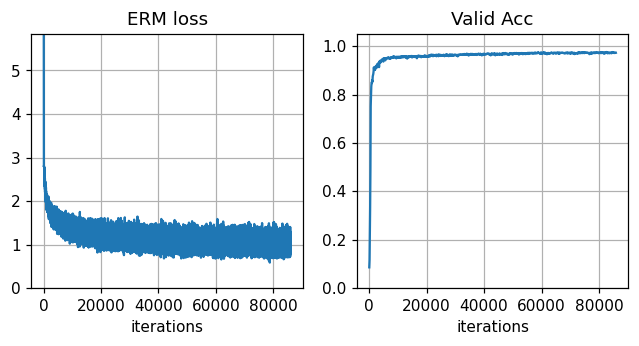

In [117]:
stats = run_experiment(model, train_dl, valid_dl, test_dl, max_epochs)
print_stats(stats)